In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mlflow
import mlflow.sklearn
import logging
import os
import joblib

logging.basicConfig(level=logging.INFO)


In [35]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model, model_name):
    """
    Train and evaluate a machine learning model, logging results with MLflow.
    
    Args:
    X_train, X_test (np.array): Training and test features
    y_train, y_test (np.array): Training and test labels
    model: Scikit-learn model object
    model_name (str): Name of the model for logging
    
    Returns:
    float: Accuracy of the model on the test set
    """
    with mlflow.start_run(run_name=model_name):
        # Log model parameters
        mlflow.log_params(model.get_params())
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        
        # Generate classification report
        clf_report = classification_report(y_test, y_pred, output_dict=True)
        for label, metrics in clf_report.items():
            if isinstance(metrics, dict):
                for metric_name, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric_name}", value)
        
        # Generate and save confusion matrix plot
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        cm_plot_path = f"plots/confusion_matrix_{model_name}.png"
        plt.savefig(cm_plot_path)
        mlflow.log_artifact(cm_plot_path)
        plt.close()
        
        # Log the model
        mlflow.sklearn.log_model(model, "model")
        
        print(f"\n{model_name} Results:")
        print(classification_report(y_test, y_pred))
        print(f"{model_name} Accuracy: {accuracy:.4f}")
        
        return accuracy


In [36]:
print(mlflow.get_tracking_uri())


file:./mlruns


In [37]:
# Set MLflow tracking URI (you can change this to your preferred location)
mlflow.set_tracking_uri("file:./mlruns")

# Set the experiment name
mlflow.set_experiment("Emotion Recognition v2")

# Load reduced features
X_reduced = np.load('data/reduced_features.npy')

# Load metadata
metadata_df = pd.read_csv('data/metadata.csv')

# Prepare data for modeling
le = LabelEncoder()
y = le.fit_transform(metadata_df['emotion'])

# save encoder
joblib.dump(le, f'utils/target_encoder.joblib')

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Log dataset info
with mlflow.start_run(run_name="Dataset Info"):
    mlflow.log_param("n_samples", len(y))
    mlflow.log_param("n_features", X_reduced.shape[1])
    mlflow.log_param("n_classes", len(np.unique(y)))

# Train and evaluate models
models = [
    (RandomForestClassifier(n_estimators=100, random_state=42), "RandomForest"),
    (SVC(kernel='rbf', random_state=42, probability=True), "SVM"),
    (MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42), "NN_1Layer"),
    (MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42), "NN_2Layers"),
    (MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000, random_state=42), "NN_3Layers"),
    (MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=1000, random_state=42), "NN_2Layers_Wide"),
]

for model, name in models:
    accuracy = train_and_evaluate_model(X_train, X_test, y_train, y_test, model, name)

print("Model training and evaluation completed.")
print(f"MLflow runs can be viewed at {mlflow.get_tracking_uri()}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



RandomForest Results:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.40        10
   macro avg       0.10      0.20      0.13        10
weighted avg       0.20      0.40      0.27        10

RandomForest Accuracy: 0.4000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/


SVM Results:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.50        10
   macro avg       0.18      0.22      0.19        10
weighted avg       0.38      0.50      0.41        10

SVM Accuracy: 0.5000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/


NN_1Layer Results:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.40        10
   macro avg       0.36      0.31      0.33        10
weighted avg       0.52      0.40      0.45        10

NN_1Layer Accuracy: 0.4000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/


NN_2Layers Results:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.40        10
   macro avg       0.18      0.18      0.18        10
weighted avg       0.39      0.40      0.39        10

NN_2Layers Accuracy: 0.4000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/


NN_3Layers Results:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.50        10
   macro avg       0.22      0.22      0.21        10
weighted avg       0.47      0.50      0.48        10

NN_3Layers Accuracy: 0.5000


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/


NN_2Layers_Wide Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.50      0.67      0.57         3
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1

    accuracy                           0.60        10
   macro avg       0.25      0.28      0.26        10
weighted avg       0.55      0.60      0.57        10

NN_2Layers_Wide Accuracy: 0.6000
Model training and evaluation completed.
MLflow runs can be viewed at file:./mlruns


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/

['angry' 'calm' 'fearful' 'happy' 'neutral' 'sad']


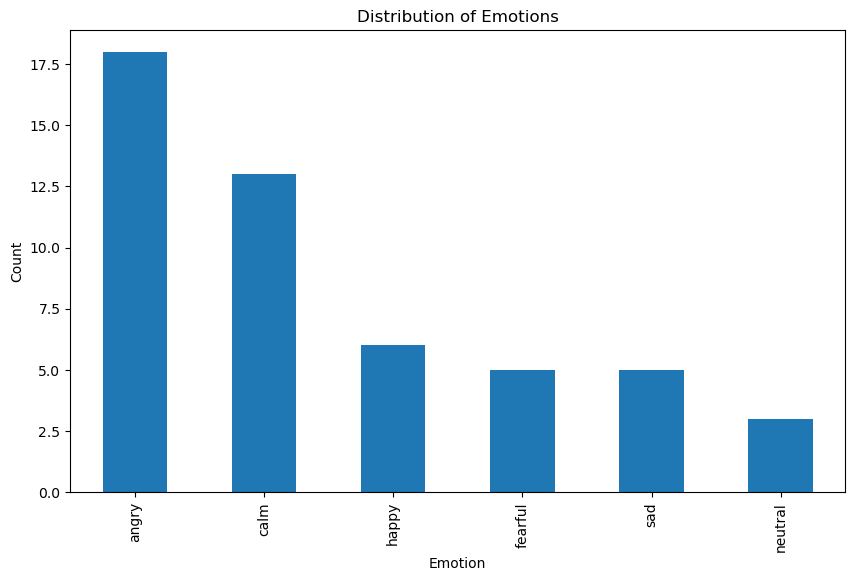

In [38]:
# View the unique emotions in your dataset
print(np.unique(metadata_df['emotion']))

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
metadata_df['emotion'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()



In [39]:
import mlflow
print(mlflow.__version__)
print(mlflow.get_tracking_uri())


2.14.3
file:./mlruns


In [ ]:
!mlflow ui --port 5002


[2024-08-10 23:32:57 -0400] [46823] [INFO] Starting gunicorn 22.0.0
[2024-08-10 23:32:57 -0400] [46823] [INFO] Listening at: http://127.0.0.1:5002 (46823)
[2024-08-10 23:32:57 -0400] [46823] [INFO] Using worker: sync
[2024-08-10 23:32:57 -0400] [46824] [INFO] Booting worker with pid: 46824
[2024-08-10 23:32:58 -0400] [46825] [INFO] Booting worker with pid: 46825
[2024-08-10 23:32:58 -0400] [46826] [INFO] Booting worker with pid: 46826
[2024-08-10 23:32:58 -0400] [46827] [INFO] Booting worker with pid: 46827
